In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
! pip install celluloid

In [3]:
from glob import glob
from celluloid import Camera
from IPython.display import HTML

In [4]:
import torch
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage

In [5]:
import imgaug.augmenters as iaa

In [6]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [7]:
# root = glob("../input/medical-segmentation-decathlon-heart/imagesTr/*/*.nii")
# label = glob("../input/medical-segmentation-decathlon-heart/labelsTr/*/*.nii")

root = Path("../input/medical-segmentation-decathlon-heart/imagesTr/")
label = Path("../input/medical-segmentation-decathlon-heart/labelsTr/")

In [8]:
def change_img_to_label_path(path):
    try:
        parts = list(path.parts)
        parts[parts.index("imagesTr")] = "labelsTr"
        return Path(*parts)
    except Exception as e:
        print(e)        

### Visualization

In [9]:
sample_path = list(root.glob("*/la*"))[0]
sample_path_label = change_img_to_label_path(sample_path)

In [10]:
sample_path, sample_path_label

(PosixPath('../input/medical-segmentation-decathlon-heart/imagesTr/la_017.nii/la_017.nii'),
 PosixPath('../input/medical-segmentation-decathlon-heart/labelsTr/la_017.nii/la_017.nii'))

In [11]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [12]:
nib.aff2axcodes(data.affine) # get orientation - right to left, anterior to posterior, superior to inferior

('R', 'A', 'S')

In [13]:
mri.shape

(320, 320, 120)

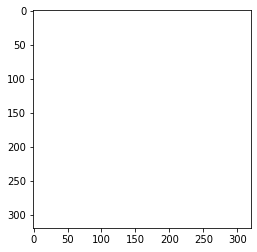

In [14]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    camera.snap()

animation = camera.animate()

In [15]:
HTML(animation.to_html5_video())

### Preprocessing

In [16]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [17]:
all_files = list(root.glob("*/la*"))
len(all_files)

20

In [18]:
save_root = Path("preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    for i in range(standardized_mri_data.shape[-1]):
        slice_ = standardized_mri_data[:, :, i]
        mask_ = label_data[:, :, i]
        
        slice_path = current_path/"data"
        mask_path = current_path/"mask"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice_)
        np.save(mask_path/str(i), mask_)

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
path = Path("preprocessed/train/0")

In [20]:
file = "50.npy"
slice_ = np.load(path/"data"/file)
mask = np.load(path/"mask"/file)

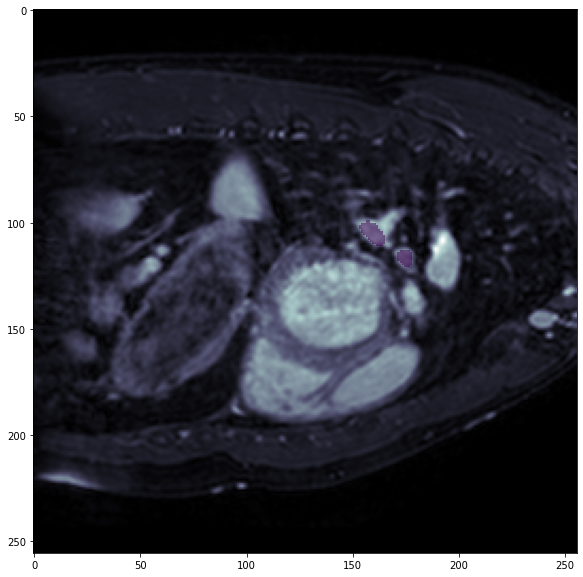

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(slice_, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, alpha=0.5)

### Dataset Class

In [22]:
class CardiacDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
        
    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):
            slice_path = subject/"data"
            for slice_ in slice_path.glob("*.npy"):
                files.append(slice_)
        return files
    
    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index("data")] = "mask"
        return Path(*parts)
    
    def augment(self, slice_, mask):
        random_seed = torch.randint(0, 100000, (1,)).item()
        imgaug.seed(random_seed)
        
        mask = SegmentationMapOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice_, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice_ = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice_, mask = self.augment(slice_, mask)
        return np.expand_dims(slice_, 0), np.expand_dims(mask, 0)

### Dataset Validation

In [23]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [24]:
path = Path("preprocessed/train/")
dataset = CardiacDataset(path, seq)

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)


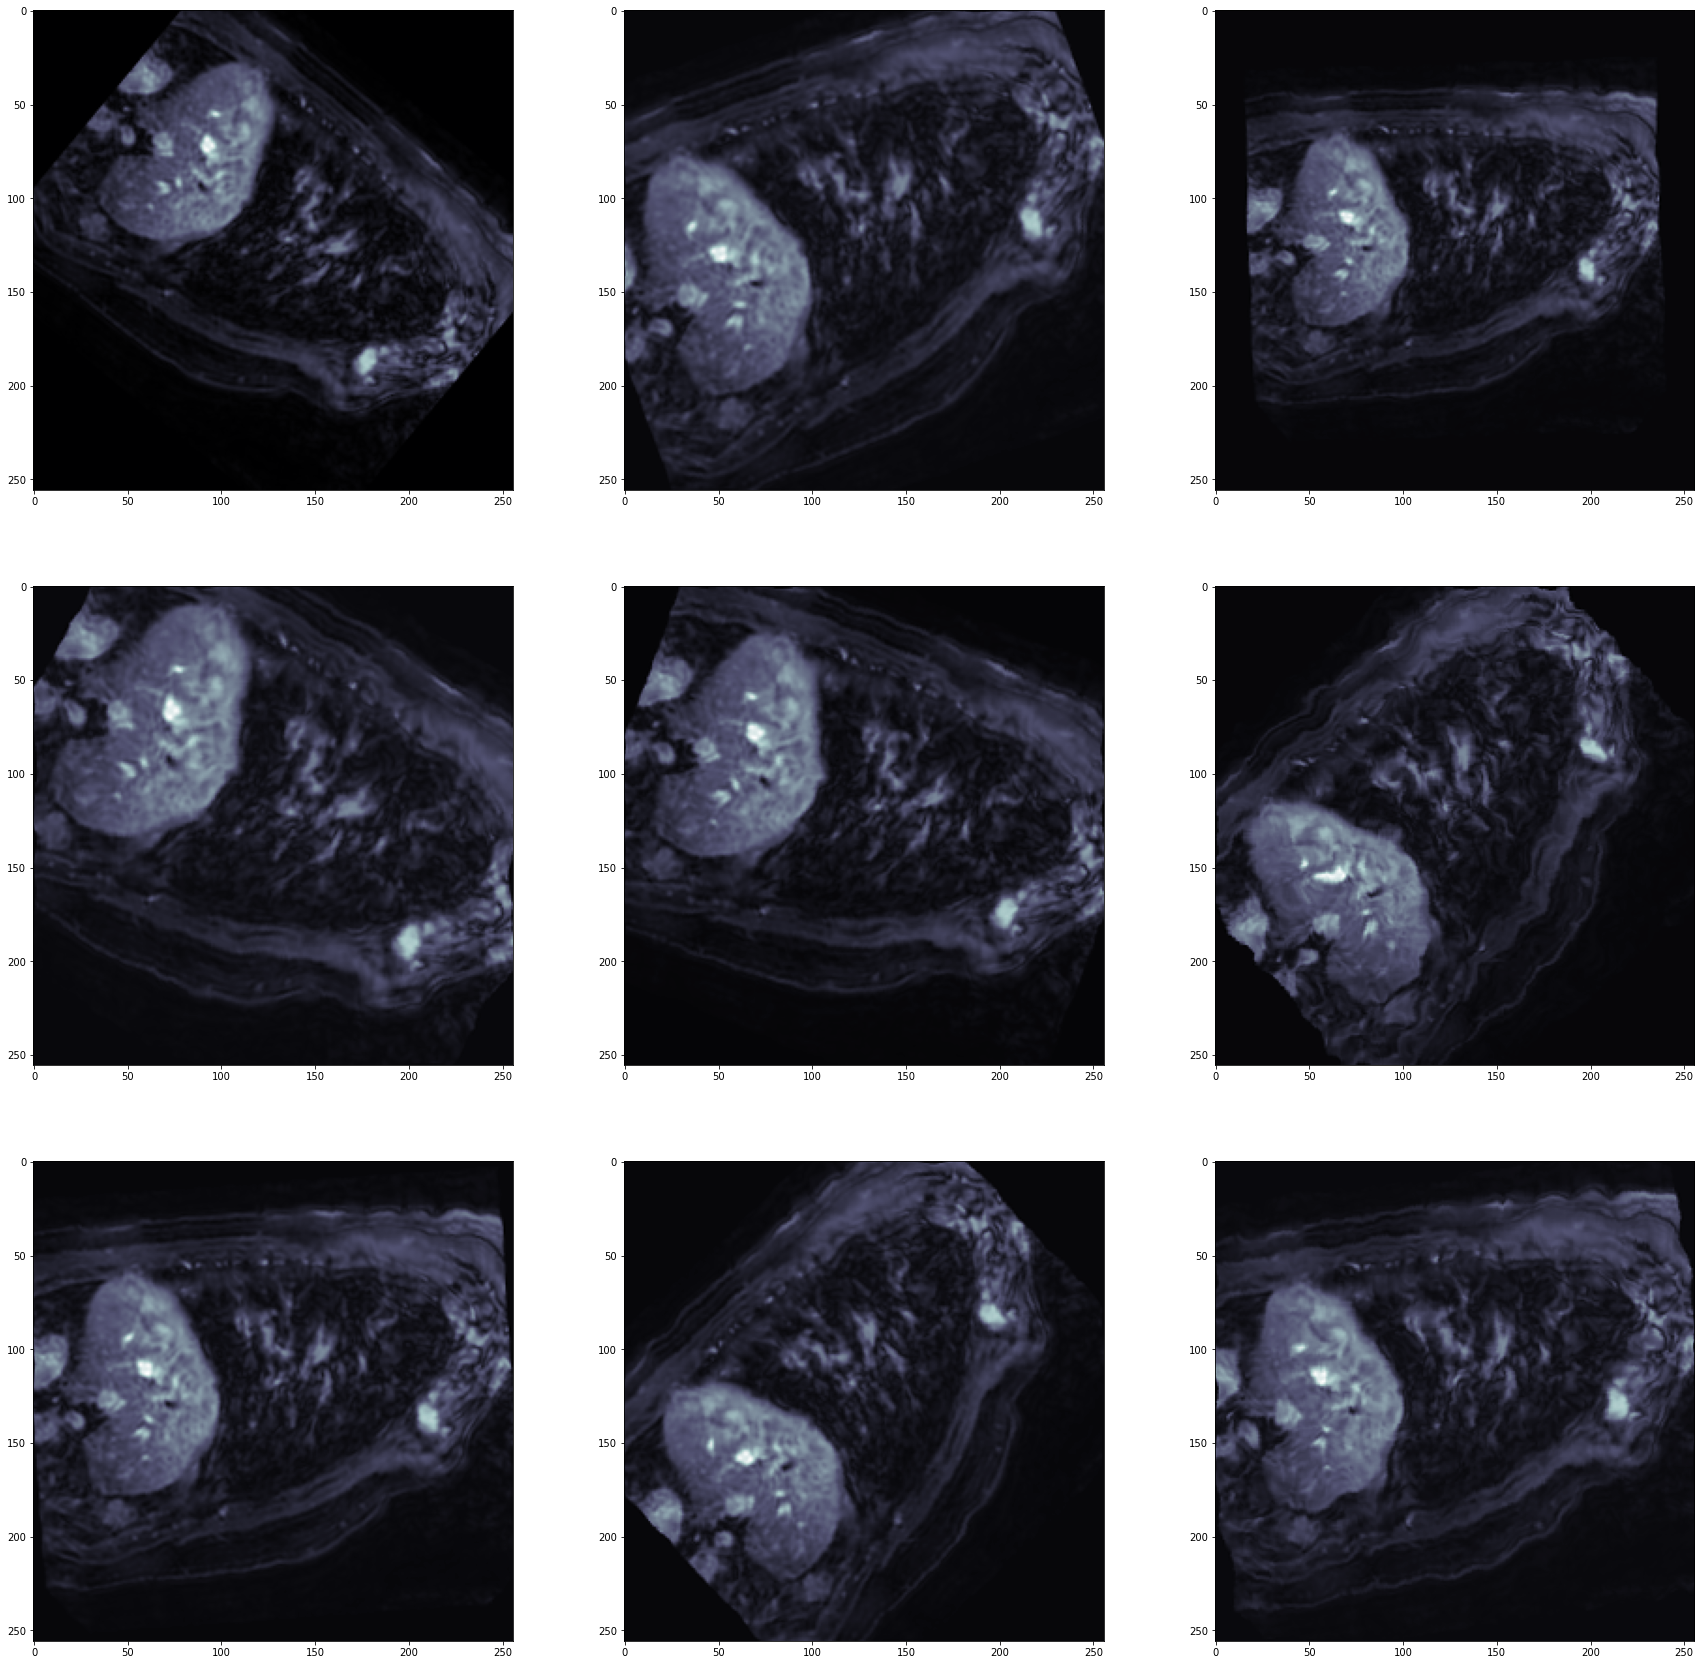

In [25]:
fig, axis = plt.subplots(3,3, figsize=(30,30))
for i in range(3):
    for j in range(3):
        slice_ , mask = dataset[1]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice_[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="bone")

### UNET

In [26]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
            torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)

In [27]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        # decoder
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool =  torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        
        # encoder
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        # decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

In [28]:
model = UNet()

In [29]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == torch.Size([1, 1, 256, 256])

### Data Loading

In [30]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [31]:
train_path = Path("preprocessed/train/")
val_path = Path("preprocessed/val/")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [32]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Custom Loss

In [33]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2*counter) / denum
        return 1 - dice        

### Model Creating

In [51]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
        
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1 ,2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        plt.imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [52]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [53]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val Dice",
    save_top_k=10,
    mode="min"
)

In [59]:
accelerator = 'gpu'
devices = 1

trainer = pl.Trainer(accelerator=accelerator, devices=devices,
                     logger=TensorBoardLogger(save_dir="logs"),
                     log_every_n_steps=1, callbacks = checkpoint_callback,
                     max_epochs=50)

In [ ]:
trainer.fit(model, train_loader, val_loader)

### Evaluation

In [62]:
import nibabel
from tqdm.notebook import tqdm
from celluloid import Camera

In [ ]:
# ../input/medical-segmentation-decathlon-heart/unet-weights

In [63]:
model = AtriumSegmentation.load_from_checkpoint("../input/medical-segmentation-decathlon-heart/unet-weights/70.ckpt")

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [66]:
preds = []
labels = []

for slice_, label in tqdm(val_dataset):
    slice_ = torch.tensor(slice_).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice_)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/360 [00:00<?, ?it/s]

In [67]:
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.9484)

### Evaluate Test Subject

In [69]:
subject = "../input/medical-segmentation-decathlon-heart/imagesTs/la_002.nii/la_002.nii"
subject_mri = nib.load(subject).get_fdata()

In [70]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [71]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice_ = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slice_).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
        
    preds.append(pred.cpu())      

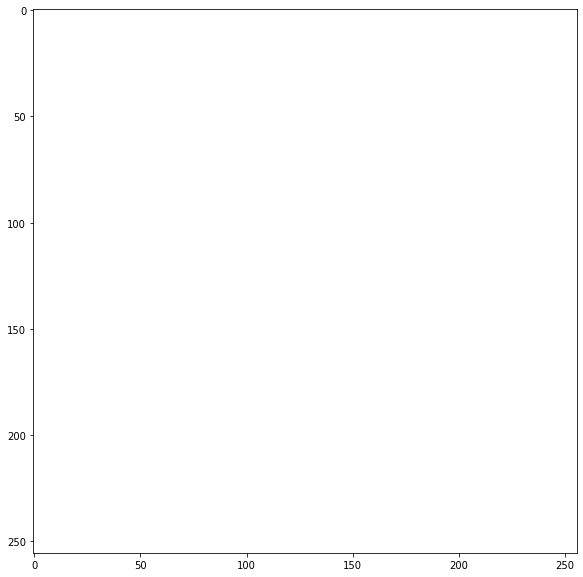

In [73]:
fig = plt.figure(figsize=(10,10))
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5)
    camera.snap()
    
animation = camera.animate()

In [75]:
HTML(animation.to_html5_video())